# CNN 1D IoT Classification Model

## Importing Libraries

In [1]:
from __future__ import print_function
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Concatenate
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import plot_model
from keras.models import Model
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import copy
import tensorflow as tf
%matplotlib inline

Using TensorFlow backend.


## Open and Read Data

In [2]:
def data():
    import tensorflow as tf
    hdf5_path = 'dataset.hdf5'
    subtract_mean = True

    hdf5_file = h5py.File(hdf5_path, "r")

    if subtract_mean:
        mm = hdf5_file["train_mean"][...,0]
        mm = mm[np.newaxis, ...]

    data_num = hdf5_file["train_flow"].shape[0]
    
    #batch_size = 512
    num_classes = 2
    epochs = 30

    flow_rows, flow_cols = 298, 17

    x_train = hdf5_file["train_flow"][...,0]
    
    if subtract_mean:
        x_train -= mm

    y_train = hdf5_file["train_labels"][:,...]
    hdf5_file.close()

    hdf5_path = 'dataset-IoT.hdf5'
    hdf5_file = h5py.File(hdf5_path, "r")


    x_test = hdf5_file["IoT_flow"][...,0]
    if subtract_mean:
        x_test -= mm

    y_test = hdf5_file["labels"][:,...]

    hdf5_file.close()

    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
    d_class_weights = dict(enumerate(class_weights))
    #print(d_class_weights)

    input_shape = (x_train.shape[1], x_train.shape[2])
    
    #print('x_train shape:', x_train.shape)
    #print(x_train.shape[0], 'train samples')
    #print(x_test.shape[0], 'test samples')
    
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return x_train, y_train, x_test, y_test

## Buld the CNN 1D Model

In [3]:
def create_model(x_train, y_train, x_test, y_test):
    num_classes = 2
    high = {{choice([40,50,60,70,80])}}
    
    filter_lenghts =  [int(i) for i in np.arange(2,high,2)]
    print(filter_lenghts)
    convs = []
    maxlen = 298
    batchSize = {{choice([128,256])}}
    epochs = 30
    numFilters={{choice([32,64,128])}}
    activations={{choice(['relu', 'sigmoid', 'tanh'])}}
    dropoutVal = {{uniform(0.1, 0.3)}}
    #lr = {{uniform(0.0009, 0.0025)}}
    optimizers={{choice([keras.optimizers.Adadelta(lr=0.001),keras.optimizers.RMSprop(lr=0.001),keras.optimizers.Adam(lr=0.001)])}}
    input_flow = Input(shape=input_shape)

    convs= {}
    mpoolings = {}
    flattens = {}
    convs_out = []
    for i in filter_lenghts:
        convs[str(i)+'_convolution']=Conv1D(filters=numFilters,kernel_size=i,padding="valid",activation=activations,strides=1)(input_flow)

        mpoolings[str(i)+'_maxpooling'] = MaxPooling1D(pool_size= maxlen - i + 1)(convs[str(i)+'_convolution'])
        flattens[str(i)+'_flattenout'] = Flatten()(mpoolings[str(i)+'_maxpooling'])
        convs_out.append(flattens[str(i)+'_flattenout'])
    out = Concatenate()(convs_out)
    dropout = Dropout(dropoutVal)(out)
    dense = Dense(64, activation='relu')(dropout)
    dense2 = Dense(32, activation='relu')(dense)
    dropout2 = Dropout(dropoutVal)(dense2)
    end = Dense(num_classes, activation='softmax')(dropout2)

    model = Model(inputs=input_flow, outputs=end) 
    model.summary()
    model.compile(loss='binary_crossentropy',optimizer=optimizers,metrics=['accuracy'])
    model.fit(x_train, y_train,batch_size=batchSize, epochs=30, verbose=0, validation_split=0.2, class_weight=class_weights, shuffle=True)
    score = model.evaluate(x_test, y_test, verbose=0)
    loss = score[0]
    return {'loss': loss, 'status': STATUS_OK, 'model': model} 

## Run Model

## Model Analysis
#### Classification Report
#### Confusion Matrix
#### Area Under Reciever Operating Characteristic Curve

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     34974
           1       0.86      0.52      0.65      7193

   micro avg       0.90      0.90      0.90     42167
   macro avg       0.88      0.75      0.80     42167
weighted avg       0.90      0.90      0.89     42167

[[34372   602]
 [ 3461  3732]]
0.9254487580219967


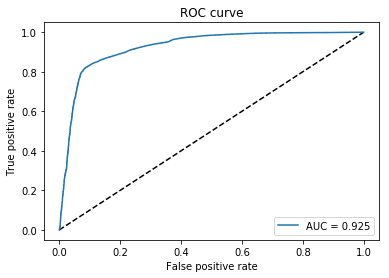

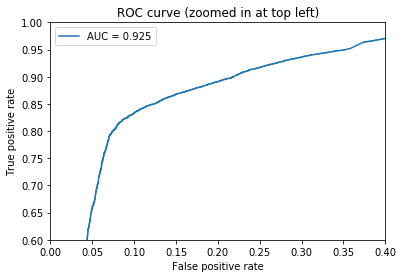

In [5]:
y_pred = best_model.predict(x_test)
yy_test = [np.argmax(i) for i in y_test]

yy_pred = [np.argmax(i) for i in y_pred]

print(classification_report(yy_test, yy_pred))     
  
new = np.vstack([yy_test,yy_pred])

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

print(confusion_matrix(yy_test, yy_pred))



y_pred_keras = best_model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(yy_test, y_pred[:,0],pos_label=0)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

f1 = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
f1.savefig("ROC-curve-cnn1D-50.pdf", bbox_inches='tight')

f2 = plt.figure()
plt.xlim(0, 0.4)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()
f2.savefig("ROC-curve-zoomed-cnn1D-50.pdf", bbox_inches='tight')

best_model.save('cnn1D-50.h5')


## Save Model Analysis Data

In [6]:
d = {'False Positive Rate': fpr_keras, 'True Positive Rate': tpr_keras , 'Thresholds': thresholds_keras}

In [7]:
roc_CNN1D = pd.DataFrame(data=d)

In [8]:
roc_CNN1D.to_csv(path_or_buf ='rocCNN1D-50.csv', index=False)

In [9]:
conf = confusion_matrix(yy_test, yy_pred)

In [10]:
conf1D=pd.DataFrame(data=conf)

In [11]:
conf1D.to_csv(path_or_buf='ConfusionCNN1D-50.csv',index=False)